<a href="https://colab.research.google.com/github/ycc789741ycc/MNIST_PCA_with_SVM/blob/master/MNIST_DATA_PROCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load MNIST with numpy

In [ ]:
import numpy as np
import cv2
import csv
from google.colab.patches import cv2_imshow

with open('/content/sample_data/mnist_train_small.csv') as f:
  csvReader = csv.reader(f)
  data = list(csvReader)
  numpyData = np.array(data)
  img_train_y = numpyData[:,0]
  img_train_x = numpyData[:,1:]


with open('/content/sample_data/mnist_test.csv') as f:
  csvReader = csv.reader(f)
  data = list(csvReader)
  numpyData = np.array(data)
  img_test_y = numpyData[:,0]
  img_test_x = numpyData[:,1:]


In [ ]:
cv2_imshow(np.uint8(img_test_x[0].reshape((28,28))))
print(img_test_y[0])

7


# Dealing dataset with PCA

### *Get eigenvector (orthonormal matrix)*


In [ ]:
img_cov = np.cov(np.float64(img_train_x.T))
u,s,vh = np.linalg.svd(img_cov)
sig_pick = 100

### *Show what PCA did*

In [ ]:
sample_s = vh@np.float64(img_test_x[0].T)
sample_s[sig_pick:] = 0
img_PCA = u@sample_s
print(img_PCA.shape)
img_PCA = np.uint8(img_PCA.reshape((28,28)))
cv2_imshow(img_PCA)

(784,)


### *Transfer data to PCA eigenspace*

In [ ]:
img_train_x = (vh@np.float32(img_train_x.T))
img_train_x = img_train_x[:sig_pick]
img_train_x = img_train_x.T
img_test_x = (vh@np.float32(img_test_x.T))
img_test_x = img_test_x[:sig_pick]
img_test_x = img_test_x.T
print(img_train_x.shape)
print(img_test_x.shape)

(20000, 100)
(10000, 100)


# Training SVM model

### *Transfer numpy to tensor and processing with data loader*

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

def DataLoaderProcess(img_train_x,img_train_y,img_test_x,img_test_y):
  img_train_x = torch.tensor(img_train_x)
  img_train_y = torch.tensor(np.int64(img_train_y))
  img_test_x = torch.tensor(img_test_x)
  img_test_y = torch.tensor(np.int64(img_test_y))
  DataSet_train = TensorDataset(img_train_x,img_train_y)
  DataSet_test = TensorDataset(img_test_x,img_test_y)
  DataLoader_train = DataLoader(DataSet_train,batch_size=64,shuffle=True)
  DataLoader_test = DataLoader(DataSet_test,batch_size=64,sampler=sampler.SubsetRandomSampler(range(5000)))
  DataLoader_val = DataLoader(DataSet_test,batch_size=64,sampler=sampler.SubsetRandomSampler(range(5000,10000)))
  return DataLoader_train, DataLoader_test, DataLoader_val

DataLoader_train, DataLoader_test, DataLoader_val = DataLoaderProcess(img_train_x,img_train_y,img_test_x,img_test_y)

dataiter = iter(DataLoader_test)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 100])
torch.Size([64])


### *model*

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LinearSVM(nn.Module):
  def __init__(self):
    super(LinearSVM, self).__init__()
    self.L1 = nn.Linear(100,256)
    nn.init.kaiming_normal_(self.L1.weight)
    self.L2 = nn.Linear(256,10)
    nn.init.kaiming_normal_(self.L2.weight)

  def forward(self, x):
    x = self.L1(x)
    x = F.layer_norm(x,x.size()[1:])
    x = F.leaky_relu(x,0.2)
    x = self.L2(x)
    return x

model = LinearSVM()
print(model)

LinearSVM(
  (L1): Linear(in_features=100, out_features=256, bias=True)
  (L2): Linear(in_features=256, out_features=10, bias=True)
)


### *Training the model with optimizer*

Epoch 0, Iteration 0, loss = 1.1360, validation accuracy = 0.053
Epoch 0, Iteration 10, loss = 0.5612, validation accuracy = 0.310
Epoch 0, Iteration 20, loss = 0.3134, validation accuracy = 0.560
Epoch 0, Iteration 30, loss = 0.2363, validation accuracy = 0.699
Epoch 0, Iteration 40, loss = 0.2403, validation accuracy = 0.780
Epoch 0, Iteration 50, loss = 0.1141, validation accuracy = 0.822
Epoch 0, Iteration 60, loss = 0.1386, validation accuracy = 0.853
Epoch 0, Iteration 70, loss = 0.0965, validation accuracy = 0.865
Epoch 0, Iteration 80, loss = 0.0841, validation accuracy = 0.881
Epoch 0, Iteration 90, loss = 0.1226, validation accuracy = 0.882
Epoch 0, Iteration 100, loss = 0.0791, validation accuracy = 0.887
Epoch 0, Iteration 110, loss = 0.0636, validation accuracy = 0.895
Epoch 0, Iteration 120, loss = 0.0717, validation accuracy = 0.904
Epoch 0, Iteration 130, loss = 0.0596, validation accuracy = 0.908
Epoch 0, Iteration 140, loss = 0.0472, validation accuracy = 0.908
Epoch 

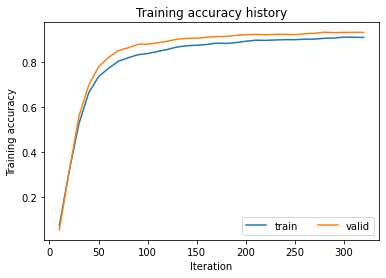

Epoch 1, Iteration 0, loss = 0.0415, validation accuracy = 0.934
Epoch 1, Iteration 10, loss = 0.0100, validation accuracy = 0.936
Epoch 1, Iteration 20, loss = 0.0421, validation accuracy = 0.937
Epoch 1, Iteration 30, loss = 0.0451, validation accuracy = 0.936
Epoch 1, Iteration 40, loss = 0.0300, validation accuracy = 0.936
Epoch 1, Iteration 50, loss = 0.0789, validation accuracy = 0.938
Epoch 1, Iteration 60, loss = 0.0710, validation accuracy = 0.938
Epoch 1, Iteration 70, loss = 0.0650, validation accuracy = 0.940
Epoch 1, Iteration 80, loss = 0.0327, validation accuracy = 0.941
Epoch 1, Iteration 90, loss = 0.0389, validation accuracy = 0.941
Epoch 1, Iteration 100, loss = 0.0543, validation accuracy = 0.943
Epoch 1, Iteration 110, loss = 0.0155, validation accuracy = 0.944
Epoch 1, Iteration 120, loss = 0.0504, validation accuracy = 0.942
Epoch 1, Iteration 130, loss = 0.0113, validation accuracy = 0.943
Epoch 1, Iteration 140, loss = 0.0218, validation accuracy = 0.943
Epoch 

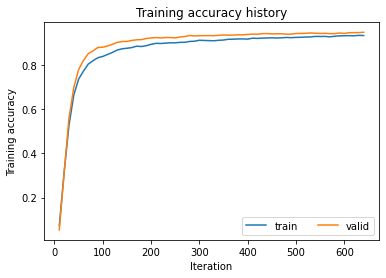

Epoch 2, Iteration 0, loss = 0.0223, validation accuracy = 0.950
Epoch 2, Iteration 10, loss = 0.0239, validation accuracy = 0.949
Epoch 2, Iteration 20, loss = 0.0435, validation accuracy = 0.948
Epoch 2, Iteration 30, loss = 0.0175, validation accuracy = 0.948
Epoch 2, Iteration 40, loss = 0.0192, validation accuracy = 0.953
Epoch 2, Iteration 50, loss = 0.0523, validation accuracy = 0.954
Epoch 2, Iteration 60, loss = 0.0381, validation accuracy = 0.953
Epoch 2, Iteration 70, loss = 0.0409, validation accuracy = 0.955
Epoch 2, Iteration 80, loss = 0.0140, validation accuracy = 0.950
Epoch 2, Iteration 90, loss = 0.0204, validation accuracy = 0.952
Epoch 2, Iteration 100, loss = 0.0441, validation accuracy = 0.954
Epoch 2, Iteration 110, loss = 0.0311, validation accuracy = 0.955
Epoch 2, Iteration 120, loss = 0.0244, validation accuracy = 0.955
Epoch 2, Iteration 130, loss = 0.0286, validation accuracy = 0.952
Epoch 2, Iteration 140, loss = 0.0217, validation accuracy = 0.954
Epoch 

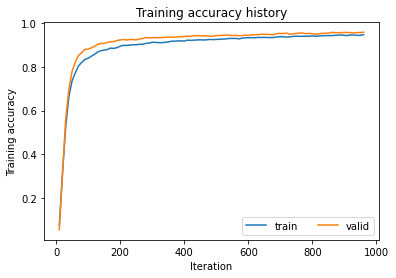

Epoch 3, Iteration 0, loss = 0.0356, validation accuracy = 0.960
Epoch 3, Iteration 10, loss = 0.0223, validation accuracy = 0.958
Epoch 3, Iteration 20, loss = 0.0070, validation accuracy = 0.958
Epoch 3, Iteration 30, loss = 0.0218, validation accuracy = 0.960
Epoch 3, Iteration 40, loss = 0.0193, validation accuracy = 0.958
Epoch 3, Iteration 50, loss = 0.0187, validation accuracy = 0.959
Epoch 3, Iteration 60, loss = 0.0148, validation accuracy = 0.960
Epoch 3, Iteration 70, loss = 0.0274, validation accuracy = 0.959
Epoch 3, Iteration 80, loss = 0.0173, validation accuracy = 0.959
Epoch 3, Iteration 90, loss = 0.0241, validation accuracy = 0.959
Epoch 3, Iteration 100, loss = 0.0182, validation accuracy = 0.960
Epoch 3, Iteration 110, loss = 0.0132, validation accuracy = 0.963
Epoch 3, Iteration 120, loss = 0.0184, validation accuracy = 0.962
Epoch 3, Iteration 130, loss = 0.0346, validation accuracy = 0.959
Epoch 3, Iteration 140, loss = 0.0160, validation accuracy = 0.960
Epoch 

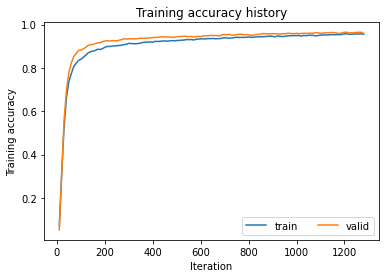

Epoch 4, Iteration 0, loss = 0.0094, validation accuracy = 0.957
Epoch 4, Iteration 10, loss = 0.0047, validation accuracy = 0.961
Epoch 4, Iteration 20, loss = 0.0075, validation accuracy = 0.962
Epoch 4, Iteration 30, loss = 0.0125, validation accuracy = 0.963
Epoch 4, Iteration 40, loss = 0.0232, validation accuracy = 0.961
Epoch 4, Iteration 50, loss = 0.0150, validation accuracy = 0.960
Epoch 4, Iteration 60, loss = 0.0183, validation accuracy = 0.961
Epoch 4, Iteration 70, loss = 0.0072, validation accuracy = 0.963
Epoch 4, Iteration 80, loss = 0.0161, validation accuracy = 0.963
Epoch 4, Iteration 90, loss = 0.0181, validation accuracy = 0.961
Epoch 4, Iteration 100, loss = 0.0149, validation accuracy = 0.961
Epoch 4, Iteration 110, loss = 0.0058, validation accuracy = 0.961
Epoch 4, Iteration 120, loss = 0.0212, validation accuracy = 0.963
Epoch 4, Iteration 130, loss = 0.0064, validation accuracy = 0.963
Epoch 4, Iteration 140, loss = 0.0108, validation accuracy = 0.963
Epoch 

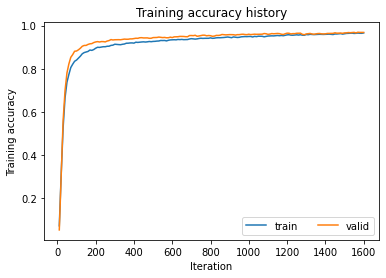

Epoch 5, Iteration 0, loss = 0.0052, validation accuracy = 0.969
Epoch 5, Iteration 10, loss = 0.0075, validation accuracy = 0.969
Epoch 5, Iteration 20, loss = 0.0164, validation accuracy = 0.969
Epoch 5, Iteration 30, loss = 0.0207, validation accuracy = 0.969
Epoch 5, Iteration 40, loss = 0.0049, validation accuracy = 0.969
Epoch 5, Iteration 50, loss = 0.0159, validation accuracy = 0.972
Epoch 5, Iteration 60, loss = 0.0070, validation accuracy = 0.968
Epoch 5, Iteration 70, loss = 0.0235, validation accuracy = 0.969
Epoch 5, Iteration 80, loss = 0.0025, validation accuracy = 0.970
Epoch 5, Iteration 90, loss = 0.0116, validation accuracy = 0.966
Epoch 5, Iteration 100, loss = 0.0037, validation accuracy = 0.965
Epoch 5, Iteration 110, loss = 0.0123, validation accuracy = 0.970
Epoch 5, Iteration 120, loss = 0.0110, validation accuracy = 0.968
Epoch 5, Iteration 130, loss = 0.0037, validation accuracy = 0.970
Epoch 5, Iteration 140, loss = 0.0310, validation accuracy = 0.971
Epoch 

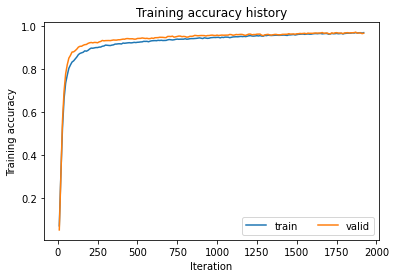

Epoch 6, Iteration 0, loss = 0.0039, validation accuracy = 0.970
Epoch 6, Iteration 10, loss = 0.0033, validation accuracy = 0.970
Epoch 6, Iteration 20, loss = 0.0137, validation accuracy = 0.971
Epoch 6, Iteration 30, loss = 0.0017, validation accuracy = 0.971
Epoch 6, Iteration 40, loss = 0.0184, validation accuracy = 0.971
Epoch 6, Iteration 50, loss = 0.0094, validation accuracy = 0.971
Epoch 6, Iteration 60, loss = 0.0051, validation accuracy = 0.973
Epoch 6, Iteration 70, loss = 0.0143, validation accuracy = 0.972
Epoch 6, Iteration 80, loss = 0.0147, validation accuracy = 0.972
Epoch 6, Iteration 90, loss = 0.0163, validation accuracy = 0.974
Epoch 6, Iteration 100, loss = 0.0051, validation accuracy = 0.973
Epoch 6, Iteration 110, loss = 0.0109, validation accuracy = 0.972
Epoch 6, Iteration 120, loss = 0.0111, validation accuracy = 0.970
Epoch 6, Iteration 130, loss = 0.0023, validation accuracy = 0.972
Epoch 6, Iteration 140, loss = 0.0162, validation accuracy = 0.968
Epoch 

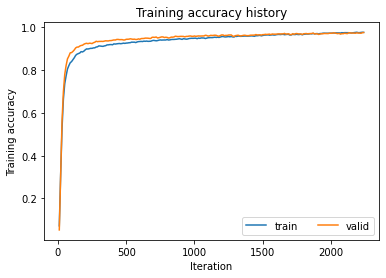

Epoch 7, Iteration 0, loss = 0.0144, validation accuracy = 0.974
Epoch 7, Iteration 10, loss = 0.0042, validation accuracy = 0.974
Epoch 7, Iteration 20, loss = 0.0117, validation accuracy = 0.971
Epoch 7, Iteration 30, loss = 0.0174, validation accuracy = 0.972
Epoch 7, Iteration 40, loss = 0.0075, validation accuracy = 0.974
Epoch 7, Iteration 50, loss = 0.0039, validation accuracy = 0.972
Epoch 7, Iteration 60, loss = 0.0027, validation accuracy = 0.973
Epoch 7, Iteration 70, loss = 0.0102, validation accuracy = 0.974
Epoch 7, Iteration 80, loss = 0.0057, validation accuracy = 0.972
Epoch 7, Iteration 90, loss = 0.0174, validation accuracy = 0.974
Epoch 7, Iteration 100, loss = 0.0085, validation accuracy = 0.973
Epoch 7, Iteration 110, loss = 0.0014, validation accuracy = 0.974
Epoch 7, Iteration 120, loss = 0.0249, validation accuracy = 0.974
Epoch 7, Iteration 130, loss = 0.0158, validation accuracy = 0.971
Epoch 7, Iteration 140, loss = 0.0070, validation accuracy = 0.971
Epoch 

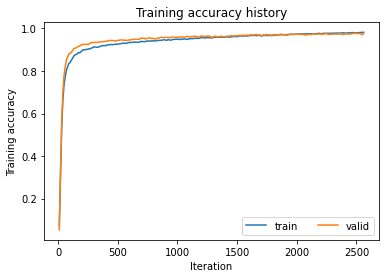

Epoch 8, Iteration 0, loss = 0.0098, validation accuracy = 0.976
Epoch 8, Iteration 10, loss = 0.0124, validation accuracy = 0.975
Epoch 8, Iteration 20, loss = 0.0008, validation accuracy = 0.976
Epoch 8, Iteration 30, loss = 0.0080, validation accuracy = 0.977
Epoch 8, Iteration 40, loss = 0.0042, validation accuracy = 0.976
Epoch 8, Iteration 50, loss = 0.0074, validation accuracy = 0.976
Epoch 8, Iteration 60, loss = 0.0014, validation accuracy = 0.976
Epoch 8, Iteration 70, loss = 0.0196, validation accuracy = 0.977
Epoch 8, Iteration 80, loss = 0.0054, validation accuracy = 0.976
Epoch 8, Iteration 90, loss = 0.0089, validation accuracy = 0.974
Epoch 8, Iteration 100, loss = 0.0045, validation accuracy = 0.976
Epoch 8, Iteration 110, loss = 0.0063, validation accuracy = 0.976
Epoch 8, Iteration 120, loss = 0.0061, validation accuracy = 0.977
Epoch 8, Iteration 130, loss = 0.0071, validation accuracy = 0.976
Epoch 8, Iteration 140, loss = 0.0051, validation accuracy = 0.976
Epoch 

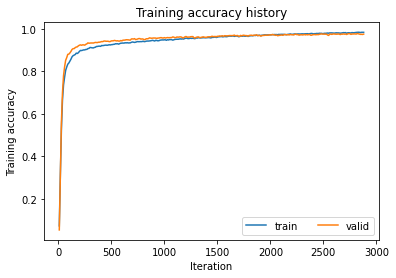

Epoch 9, Iteration 0, loss = 0.0052, validation accuracy = 0.975
Epoch 9, Iteration 10, loss = 0.0124, validation accuracy = 0.975
Epoch 9, Iteration 20, loss = 0.0023, validation accuracy = 0.976
Epoch 9, Iteration 30, loss = 0.0064, validation accuracy = 0.976
Epoch 9, Iteration 40, loss = 0.0024, validation accuracy = 0.977
Epoch 9, Iteration 50, loss = 0.0048, validation accuracy = 0.976
Epoch 9, Iteration 60, loss = 0.0067, validation accuracy = 0.977
Epoch 9, Iteration 70, loss = 0.0014, validation accuracy = 0.976
Epoch 9, Iteration 80, loss = 0.0100, validation accuracy = 0.976
Epoch 9, Iteration 90, loss = 0.0053, validation accuracy = 0.976
Epoch 9, Iteration 100, loss = 0.0114, validation accuracy = 0.975
Epoch 9, Iteration 110, loss = 0.0017, validation accuracy = 0.976
Epoch 9, Iteration 120, loss = 0.0091, validation accuracy = 0.975
Epoch 9, Iteration 130, loss = 0.0095, validation accuracy = 0.977
Epoch 9, Iteration 140, loss = 0.0067, validation accuracy = 0.980
Epoch 

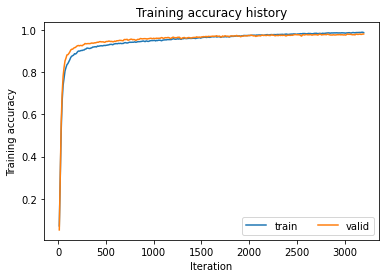

Epoch 10, Iteration 0, loss = 0.0055, validation accuracy = 0.979
Epoch 10, Iteration 10, loss = 0.0040, validation accuracy = 0.979
Epoch 10, Iteration 20, loss = 0.0112, validation accuracy = 0.979
Epoch 10, Iteration 30, loss = 0.0091, validation accuracy = 0.980
Epoch 10, Iteration 40, loss = 0.0049, validation accuracy = 0.979
Epoch 10, Iteration 50, loss = 0.0058, validation accuracy = 0.979
Epoch 10, Iteration 60, loss = 0.0122, validation accuracy = 0.978
Epoch 10, Iteration 70, loss = 0.0018, validation accuracy = 0.978
Epoch 10, Iteration 80, loss = 0.0053, validation accuracy = 0.978
Epoch 10, Iteration 90, loss = 0.0044, validation accuracy = 0.978
Epoch 10, Iteration 100, loss = 0.0034, validation accuracy = 0.978
Epoch 10, Iteration 110, loss = 0.0081, validation accuracy = 0.979
Epoch 10, Iteration 120, loss = 0.0002, validation accuracy = 0.978
Epoch 10, Iteration 130, loss = 0.0052, validation accuracy = 0.980
Epoch 10, Iteration 140, loss = 0.0049, validation accuracy

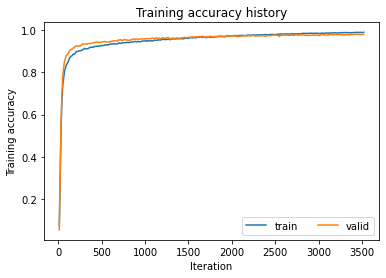

Epoch 11, Iteration 0, loss = 0.0034, validation accuracy = 0.980
Epoch 11, Iteration 10, loss = 0.0191, validation accuracy = 0.982
Epoch 11, Iteration 20, loss = 0.0025, validation accuracy = 0.980
Epoch 11, Iteration 30, loss = 0.0014, validation accuracy = 0.981
Epoch 11, Iteration 40, loss = 0.0021, validation accuracy = 0.982
Epoch 11, Iteration 50, loss = 0.0011, validation accuracy = 0.982
Epoch 11, Iteration 60, loss = 0.0101, validation accuracy = 0.983
Epoch 11, Iteration 70, loss = 0.0009, validation accuracy = 0.980
Epoch 11, Iteration 80, loss = 0.0038, validation accuracy = 0.979
Epoch 11, Iteration 90, loss = 0.0031, validation accuracy = 0.979
Epoch 11, Iteration 100, loss = 0.0028, validation accuracy = 0.979
Epoch 11, Iteration 110, loss = 0.0039, validation accuracy = 0.982
Epoch 11, Iteration 120, loss = 0.0050, validation accuracy = 0.982
Epoch 11, Iteration 130, loss = 0.0029, validation accuracy = 0.981
Epoch 11, Iteration 140, loss = 0.0044, validation accuracy

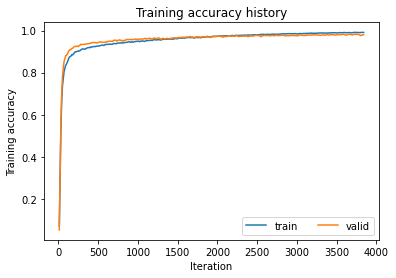

Epoch 12, Iteration 0, loss = 0.0035, validation accuracy = 0.980
Epoch 12, Iteration 10, loss = 0.0066, validation accuracy = 0.979
Epoch 12, Iteration 20, loss = 0.0035, validation accuracy = 0.979
Epoch 12, Iteration 30, loss = 0.0059, validation accuracy = 0.980
Epoch 12, Iteration 40, loss = 0.0035, validation accuracy = 0.979
Epoch 12, Iteration 50, loss = 0.0030, validation accuracy = 0.980
Epoch 12, Iteration 60, loss = 0.0011, validation accuracy = 0.981
Epoch 12, Iteration 70, loss = 0.0098, validation accuracy = 0.979
Epoch 12, Iteration 80, loss = 0.0020, validation accuracy = 0.980
Epoch 12, Iteration 90, loss = 0.0104, validation accuracy = 0.981
Epoch 12, Iteration 100, loss = 0.0041, validation accuracy = 0.980
Epoch 12, Iteration 110, loss = 0.0039, validation accuracy = 0.979
Epoch 12, Iteration 120, loss = 0.0020, validation accuracy = 0.980
Epoch 12, Iteration 130, loss = 0.0013, validation accuracy = 0.978
Epoch 12, Iteration 140, loss = 0.0018, validation accuracy

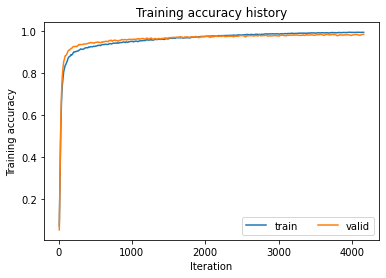

Epoch 13, Iteration 0, loss = 0.0008, validation accuracy = 0.982
Epoch 13, Iteration 10, loss = 0.0018, validation accuracy = 0.980
Epoch 13, Iteration 20, loss = 0.0006, validation accuracy = 0.981
Epoch 13, Iteration 30, loss = 0.0026, validation accuracy = 0.982
Epoch 13, Iteration 40, loss = 0.0003, validation accuracy = 0.981
Epoch 13, Iteration 50, loss = 0.0057, validation accuracy = 0.981
Epoch 13, Iteration 60, loss = 0.0003, validation accuracy = 0.981
Epoch 13, Iteration 70, loss = 0.0010, validation accuracy = 0.980
Epoch 13, Iteration 80, loss = 0.0043, validation accuracy = 0.981
Epoch 13, Iteration 90, loss = 0.0055, validation accuracy = 0.980
Epoch 13, Iteration 100, loss = 0.0022, validation accuracy = 0.980
Epoch 13, Iteration 110, loss = 0.0036, validation accuracy = 0.981
Epoch 13, Iteration 120, loss = 0.0034, validation accuracy = 0.981
Epoch 13, Iteration 130, loss = 0.0087, validation accuracy = 0.980
Epoch 13, Iteration 140, loss = 0.0016, validation accuracy

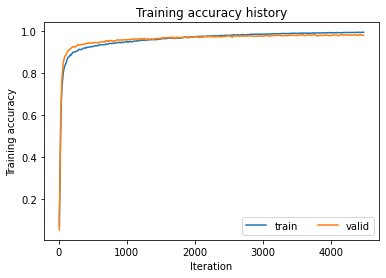

Epoch 14, Iteration 0, loss = 0.0062, validation accuracy = 0.980
Epoch 14, Iteration 10, loss = 0.0024, validation accuracy = 0.980
Epoch 14, Iteration 20, loss = 0.0035, validation accuracy = 0.982
Epoch 14, Iteration 30, loss = 0.0025, validation accuracy = 0.981
Epoch 14, Iteration 40, loss = 0.0005, validation accuracy = 0.981
Epoch 14, Iteration 50, loss = 0.0047, validation accuracy = 0.981
Epoch 14, Iteration 60, loss = 0.0005, validation accuracy = 0.983
Epoch 14, Iteration 70, loss = 0.0040, validation accuracy = 0.982
Epoch 14, Iteration 80, loss = 0.0006, validation accuracy = 0.983
Epoch 14, Iteration 90, loss = 0.0047, validation accuracy = 0.982
Epoch 14, Iteration 100, loss = 0.0015, validation accuracy = 0.982
Epoch 14, Iteration 110, loss = 0.0004, validation accuracy = 0.983
Epoch 14, Iteration 120, loss = 0.0022, validation accuracy = 0.980
Epoch 14, Iteration 130, loss = 0.0016, validation accuracy = 0.981
Epoch 14, Iteration 140, loss = 0.0036, validation accuracy

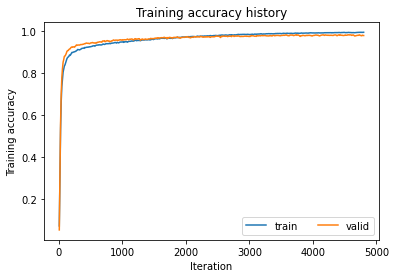

Epoch 15, Iteration 0, loss = 0.0013, validation accuracy = 0.979
Epoch 15, Iteration 10, loss = 0.0010, validation accuracy = 0.980
Epoch 15, Iteration 20, loss = 0.0008, validation accuracy = 0.980
Epoch 15, Iteration 30, loss = 0.0057, validation accuracy = 0.980
Epoch 15, Iteration 40, loss = 0.0021, validation accuracy = 0.981
Epoch 15, Iteration 50, loss = 0.0029, validation accuracy = 0.981
Epoch 15, Iteration 60, loss = 0.0005, validation accuracy = 0.982
Epoch 15, Iteration 70, loss = 0.0006, validation accuracy = 0.981
Epoch 15, Iteration 80, loss = 0.0001, validation accuracy = 0.980
Epoch 15, Iteration 90, loss = 0.0017, validation accuracy = 0.981
Epoch 15, Iteration 100, loss = 0.0041, validation accuracy = 0.980
Epoch 15, Iteration 110, loss = 0.0036, validation accuracy = 0.980
Epoch 15, Iteration 120, loss = 0.0071, validation accuracy = 0.981
Epoch 15, Iteration 130, loss = 0.0010, validation accuracy = 0.981
Epoch 15, Iteration 140, loss = 0.0008, validation accuracy

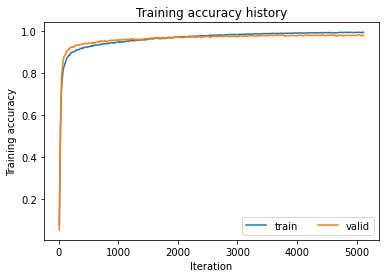

Epoch 16, Iteration 0, loss = 0.0029, validation accuracy = 0.981
Epoch 16, Iteration 10, loss = 0.0017, validation accuracy = 0.982
Epoch 16, Iteration 20, loss = 0.0045, validation accuracy = 0.981
Epoch 16, Iteration 30, loss = 0.0024, validation accuracy = 0.981
Epoch 16, Iteration 40, loss = 0.0002, validation accuracy = 0.982
Epoch 16, Iteration 50, loss = 0.0005, validation accuracy = 0.982
Epoch 16, Iteration 60, loss = 0.0011, validation accuracy = 0.980
Epoch 16, Iteration 70, loss = 0.0023, validation accuracy = 0.979
Epoch 16, Iteration 80, loss = 0.0002, validation accuracy = 0.980
Epoch 16, Iteration 90, loss = 0.0011, validation accuracy = 0.982
Epoch 16, Iteration 100, loss = 0.0000, validation accuracy = 0.980
Epoch 16, Iteration 110, loss = 0.0021, validation accuracy = 0.978
Epoch 16, Iteration 120, loss = 0.0037, validation accuracy = 0.979
Epoch 16, Iteration 130, loss = 0.0064, validation accuracy = 0.981
Epoch 16, Iteration 140, loss = 0.0050, validation accuracy

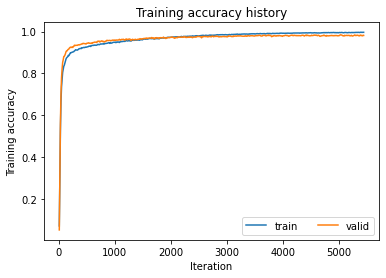

Epoch 17, Iteration 0, loss = 0.0012, validation accuracy = 0.981
Epoch 17, Iteration 10, loss = 0.0034, validation accuracy = 0.981
Epoch 17, Iteration 20, loss = 0.0017, validation accuracy = 0.982
Epoch 17, Iteration 30, loss = 0.0018, validation accuracy = 0.982
Epoch 17, Iteration 40, loss = 0.0010, validation accuracy = 0.980
Epoch 17, Iteration 50, loss = 0.0021, validation accuracy = 0.984
Epoch 17, Iteration 60, loss = 0.0033, validation accuracy = 0.982
Epoch 17, Iteration 70, loss = 0.0014, validation accuracy = 0.983
Epoch 17, Iteration 80, loss = 0.0006, validation accuracy = 0.981
Epoch 17, Iteration 90, loss = 0.0011, validation accuracy = 0.981
Epoch 17, Iteration 100, loss = 0.0070, validation accuracy = 0.981
Epoch 17, Iteration 110, loss = 0.0006, validation accuracy = 0.979
Epoch 17, Iteration 120, loss = 0.0022, validation accuracy = 0.979
Epoch 17, Iteration 130, loss = 0.0010, validation accuracy = 0.981
Epoch 17, Iteration 140, loss = 0.0027, validation accuracy

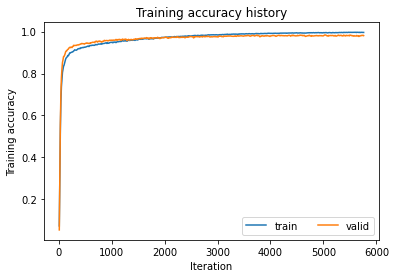

Epoch 18, Iteration 0, loss = 0.0007, validation accuracy = 0.981
Epoch 18, Iteration 10, loss = 0.0060, validation accuracy = 0.979
Epoch 18, Iteration 20, loss = 0.0024, validation accuracy = 0.981
Epoch 18, Iteration 30, loss = 0.0036, validation accuracy = 0.982
Epoch 18, Iteration 40, loss = 0.0022, validation accuracy = 0.981
Epoch 18, Iteration 50, loss = 0.0019, validation accuracy = 0.982
Epoch 18, Iteration 60, loss = 0.0005, validation accuracy = 0.981
Epoch 18, Iteration 70, loss = 0.0046, validation accuracy = 0.981
Epoch 18, Iteration 80, loss = 0.0002, validation accuracy = 0.981
Epoch 18, Iteration 90, loss = 0.0024, validation accuracy = 0.979
Epoch 18, Iteration 100, loss = 0.0062, validation accuracy = 0.981
Epoch 18, Iteration 110, loss = 0.0056, validation accuracy = 0.980
Epoch 18, Iteration 120, loss = 0.0006, validation accuracy = 0.980
Epoch 18, Iteration 130, loss = 0.0045, validation accuracy = 0.980
Epoch 18, Iteration 140, loss = 0.0000, validation accuracy

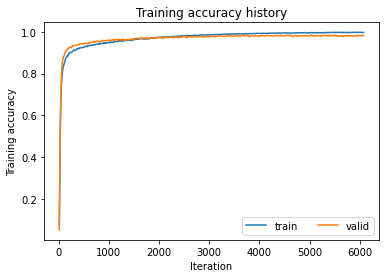

Epoch 19, Iteration 0, loss = 0.0000, validation accuracy = 0.981
Epoch 19, Iteration 10, loss = 0.0003, validation accuracy = 0.982
Epoch 19, Iteration 20, loss = 0.0013, validation accuracy = 0.983
Epoch 19, Iteration 30, loss = 0.0042, validation accuracy = 0.984
Epoch 19, Iteration 40, loss = 0.0009, validation accuracy = 0.983
Epoch 19, Iteration 50, loss = 0.0014, validation accuracy = 0.983
Epoch 19, Iteration 60, loss = 0.0057, validation accuracy = 0.984
Epoch 19, Iteration 70, loss = 0.0012, validation accuracy = 0.984
Epoch 19, Iteration 80, loss = 0.0012, validation accuracy = 0.983
Epoch 19, Iteration 90, loss = 0.0014, validation accuracy = 0.984
Epoch 19, Iteration 100, loss = 0.0054, validation accuracy = 0.983
Epoch 19, Iteration 110, loss = 0.0043, validation accuracy = 0.984
Epoch 19, Iteration 120, loss = 0.0013, validation accuracy = 0.981
Epoch 19, Iteration 130, loss = 0.0033, validation accuracy = 0.981
Epoch 19, Iteration 140, loss = 0.0004, validation accuracy

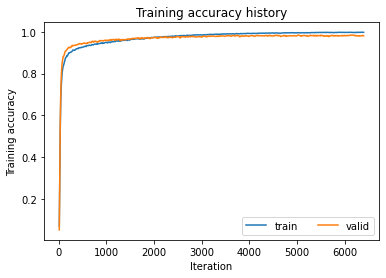

In iteration 5030 has highest validation accuracy = 0.984


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def check_accuracy(model,DataLoader_test,device=torch.device('cpu')):
  model = model.to(device=device)
  model.eval()
  num_correct = 0
  num_samples = 0
  with torch.no_grad():
    for x, y in DataLoader_test:
      x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
  acc = float(num_correct) / num_samples
  return acc

def training_visualization(iter_plt,train_acc_plt,val_acc_plt):
  plt.plot(iter_plt,train_acc_plt,label = 'train')
  plt.plot(iter_plt,val_acc_plt,label = 'valid')
  plt.title("Training accuracy history")
  plt.xlabel("Iteration")
  plt.ylabel("Training accuracy")
  plt.legend(loc="best", ncol=2)
  plt.show()

def training_model(model,loss_function,optimizer,DataLoader_train,DataLoader_val,epochs=10,print_every=10):
  if (torch.cuda.is_available()):
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')
  train_acc_plt = []
  val_acc_plt = []
  iter_plt = []
  iter_accum = 0
  model = model.to(device=device)
  best_model = model
  best_val_acc = check_accuracy(model,DataLoader_val)
  best_iter = 0
  for i in range(epochs):
    for j, (train_x, train_y) in enumerate(DataLoader_train):
      model.train()
      train_x = train_x.to(device=device,dtype=torch.float32)
      train_y = train_y.to(device=device,dtype=torch.long)
      scores = model(train_x)
      loss = loss_function(scores, train_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if j % print_every == 0:
        train_acc = check_accuracy(model,DataLoader_train,device)
        val_acc = check_accuracy(model,DataLoader_val,device)
        iter_accum += print_every
        train_acc_plt.append(train_acc)
        val_acc_plt.append(val_acc)
        iter_plt.append(iter_accum)
        print('Epoch %d, Iteration %d, loss = %.4f, validation accuracy = %.3f' % (i, j, loss.item(), val_acc))
        if (val_acc > best_val_acc):
          best_val_acc = val_acc
          best_model = model
          best_iter = iter_accum
    training_visualization(iter_plt,train_acc_plt,val_acc_plt)
  model.load_state_dict(best_model.state_dict())
  print('In iteration %d has highest validation accuracy = %.3f' % (best_iter, best_val_acc))

learning_rate = 1e-3
hingeloss = nn.MultiMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_model(model,hingeloss,optimizer,DataLoader_train,DataLoader_val,20)

# Check accuracy in testing data

In [ ]:
print('Testing accuracy = %.3f' % (check_accuracy(model,DataLoader_test)))


Testing accuracy = 0.955
